## **https://tomaugspurger.github.io/modern-5-tidy.html**
### NBA主客队休息天数是否对胜率产生影响？

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

if int(os.environ.get("MODERN_PANDAS_EPUB", 0)):
    import prep # noqa

pd.options.display.max_rows = 10
sns.set(style='ticks', context='talk')

In [3]:
# 读取数据，pd.read_html可以解析简单的html网页
fp = 'nba-2019.csv'
if not os.path.exists(fp):
    tables=pd.read_html('http://www.basketball-reference.com/leagues/NBA_2019_games.html')
    games = tables[0]
    games.to_csv(fp)
else:
    games = pd.read_csv(fp)
games.head()

,Unnamed: 0,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes
0,0,"Tue, Oct 16, 2018",8:00p,Philadelphia 76ers,87,Boston Celtics,105,Box Score,NaN,18624,NaN
1,1,"Tue, Oct 16, 2018",10:30p,Oklahoma City Thunder,100,Golden State Warriors,108,Box Score,NaN,19596,NaN
2,2,"Wed, Oct 17, 2018",7:00p,Milwaukee Bucks,113,Charlotte Hornets,112,Box Score,NaN,17889,NaN
3,3,"Wed, Oct 17, 2018",7:00p,Brooklyn Nets,100,Detroit Pistons,103,Box Score,NaN,20332,NaN
4,4,"Wed, Oct 17, 2018",7:00p,Memphis Grizzlies,83,Indiana Pacers,111,Box Score,NaN,17923,NaN


In [4]:
# column_names = {
#     'Date':'date','Start (ET)':'start',
#     'Visitor/Neutral':'away_team',
#     'PTS':'away_points',
#     'HOME/Neutral':'home_team',
#     'PTS.1':'home_points',
#     'Unnamed: 6':'box',
#     'Unnamed: 7':'n_ot',
#     'Attend.':'attendence',
#     'Notes':'notes'}

# games = (games.rename(columns=column_names)
#         .dropna(thresh=4)
#         [['date','away_team','away_points','home_team','home_points']]
#         .assign(date=lambda x:pd.to_datetime(x['date'],format='%a,%b,%d,%Y'))
#         .set_index('date',append=True)
#         .rename_axis(['game_id','date'])
#         .sort_index())
# games.head()

column_names = {'Date': 'date', 'Start (ET)': 'start',
                'Unamed: 2': 'box', 'Visitor/Neutral': 'away_team', 
                'PTS': 'away_points', 'Home/Neutral': 'home_team',
                'PTS.1': 'home_points', 'Unamed: 7': 'n_ot',
                'Attend.':'attendence'}

game = (games.rename(columns=column_names)
    .dropna(thresh=4)
    [['date', 'away_team', 'away_points', 'home_team', 'home_points','attendence']]
    .assign(date=lambda x: pd.to_datetime(x['date'], format='%a, %b %d, %Y'))
    .set_index('date', append=True)
    .rename_axis(["game_id", "date"])
    .sort_index())
game.head()

,,away_team,away_points,home_team,home_points,attendence
game_id,date,,,,,
0,2018-10-16,Philadelphia 76ers,87,Boston Celtics,105,18624
1,2018-10-16,Oklahoma City Thunder,100,Golden State Warriors,108,19596
2,2018-10-17,Milwaukee Bucks,113,Charlotte Hornets,112,17889
3,2018-10-17,Brooklyn Nets,100,Detroit Pistons,103,20332
4,2018-10-17,Memphis Grizzlies,83,Indiana Pacers,111,17923


### How many days of rest did each team get between each game?

In [5]:
# pd.melt()方法将多列融合成一列
tidy = pd.melt(game.reset_index(),
              id_vars=['game_id','date'],
              value_vars=['away_team','home_team'],
              value_name='team')
tidy.head()

,game_id,date,variable,team
0,0,2018-10-16,away_team,Philadelphia 76ers
1,1,2018-10-16,away_team,Oklahoma City Thunder
2,2,2018-10-17,away_team,Milwaukee Bucks
3,3,2018-10-17,away_team,Brooklyn Nets
4,4,2018-10-17,away_team,Memphis Grizzlies


In [6]:
tidy.groupby('team')['date'].diff().dt.days-1

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
215    1.0
216    1.0
217    6.0
218    5.0
219    6.0
Name: date, Length: 220, dtype: float64

In [7]:
tidy['rest'] = tidy.sort_values('date').groupby('team').date.diff().dt.days-1
tidy.dropna().head()

,game_id,date,variable,team,rest
14,14,2018-10-18,away_team,Miami Heat,0.0
16,16,2018-10-19,away_team,Charlotte Hornets,1.0
17,17,2018-10-19,away_team,New York Knicks,1.0
18,18,2018-10-19,away_team,Atlanta Hawks,1.0
19,19,2018-10-19,away_team,Cleveland Cavaliers,1.0


In [8]:
by_game=(pd.pivot_table(tidy,values='rest',
                       index=['game_id','date'],
                       columns='variable')
        .rename(columns={'away_team':'away_rest',
                        'home_team':'home_rest'}))
df = pd.concat([game,by_game],axis=1)
df.dropna().head()

,,away_team,away_points,home_team,home_points,attendence,away_rest,home_rest
game_id,date,,,,,,,
16,2018-10-19,Charlotte Hornets,120,Orlando Magic,88,17668,1.0,1.0
17,2018-10-19,New York Knicks,105,Brooklyn Nets,107,17732,1.0,1.0
18,2018-10-19,Atlanta Hawks,117,Memphis Grizzlies,131,17019,1.0,1.0
19,2018-10-19,Cleveland Cavaliers,123,Minnesota Timberwolves,131,18978,1.0,1.0
20,2018-10-19,Sacramento Kings,129,New Orleans Pelicans,149,18337,1.0,1.0


/Users/frank-lsy/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/frank-lsy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


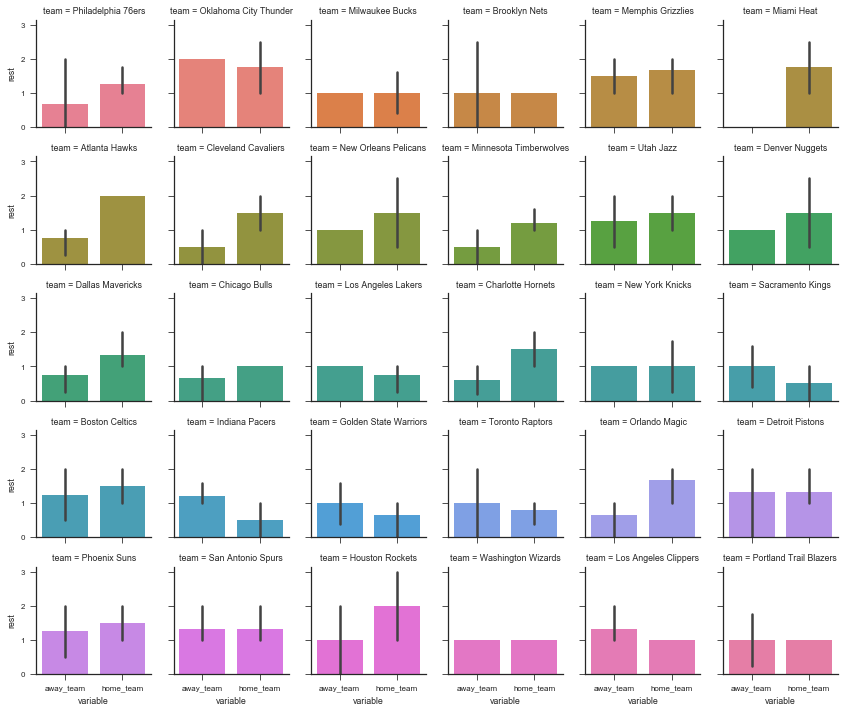

In [9]:
sns.set(style='ticks', context='paper')
g = sns.FacetGrid(tidy, col='team', col_wrap=6, hue='team', size=2)
g.map(sns.barplot, 'variable', 'rest');

- No big difference of rest days for most of the teams.
- Home rest slightly higher than away rest for most of the teams.
- Extreme location (very north or very south) teams have unstable home/away rest-days ratio.

In [10]:
df['home_win'] = df['home_points'] > df['away_points']
df['rest_spread'] = df['home_rest']-df['away_rest']
df.dropna().head()

,,away_team,away_points,home_team,home_points,attendence,away_rest,home_rest,home_win,rest_spread
game_id,date,,,,,,,,,
16,2018-10-19,Charlotte Hornets,120,Orlando Magic,88,17668,1.0,1.0,False,0.0
17,2018-10-19,New York Knicks,105,Brooklyn Nets,107,17732,1.0,1.0,True,0.0
18,2018-10-19,Atlanta Hawks,117,Memphis Grizzlies,131,17019,1.0,1.0,True,0.0
19,2018-10-19,Cleveland Cavaliers,123,Minnesota Timberwolves,131,18978,1.0,1.0,True,0.0
20,2018-10-19,Sacramento Kings,129,New Orleans Pelicans,149,18337,1.0,1.0,True,0.0


[Text(0,0.5,'Games'), Text(0.5,0,'Difference in Rest (Home-Away)')]

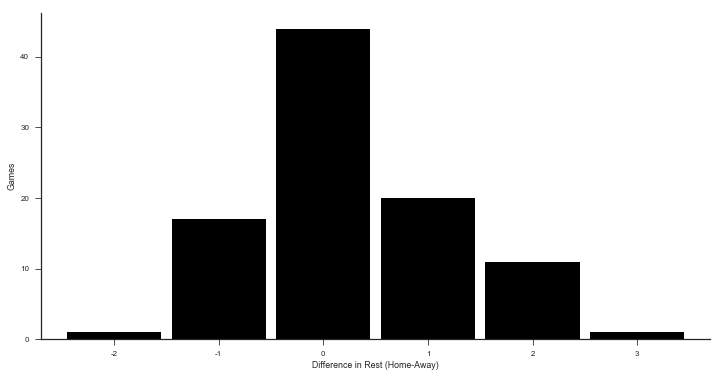

In [11]:
delta = (by_game.home_rest-by_game.away_rest).dropna().astype(int)
ax = (delta.value_counts()
     .reindex(np.arange(delta.min(),delta.max()+1),fill_value=0)
     .sort_index()
     .plot(kind='bar',color='k',width=.9,rot=0,figsize=(12,6)))
sns.despine()
ax.set(xlabel='Difference in Rest (Home-Away)',ylabel='Games')

/Users/frank-lsy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


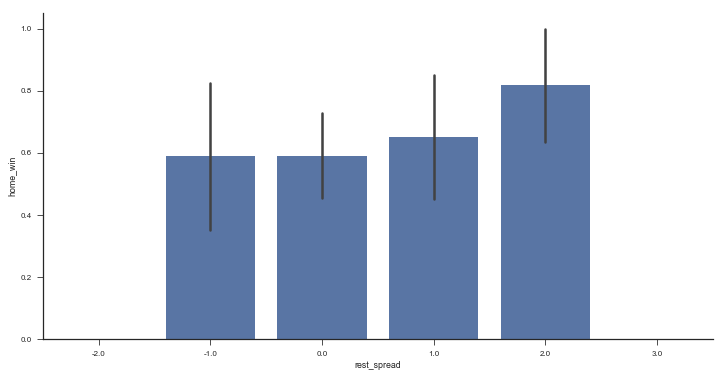

In [12]:
# fig,ax = plt.subplots(figsize=(12,6))
# sns.barplot(x='rest_spread',y='home_win',date=df.query('-2<=rest_spread<=3'),
#            color='#4c72b0',ax=ax)
# sns.despine()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='rest_spread', y='home_win', data=df.query('-5 <= rest_spread <= 5'),
            color='#4c72b0', ax=ax)
sns.despine()

- 总体来说主客场休息天数没差，服从均值为0的正态分布
- 休息时间差超过2天会对胜率产生较大影响

### Stack /Unstack
pandas has 2 useful methods for quickly converting from wide to long format(stack) and long to wide(unstack).

In [13]:
rest = (tidy.groupby(['date','variable'])
       .rest.mean()
       .dropna())
rest.head()
rest.unstack().head()

variable,away_team,home_team
date,,
2018-10-18,0.000000,1.000000
2018-10-19,1.333333,1.000000
2018-10-20,0.800000,1.000000
2018-10-21,0.750000,0.750000
2018-10-22,1.111111,1.111111


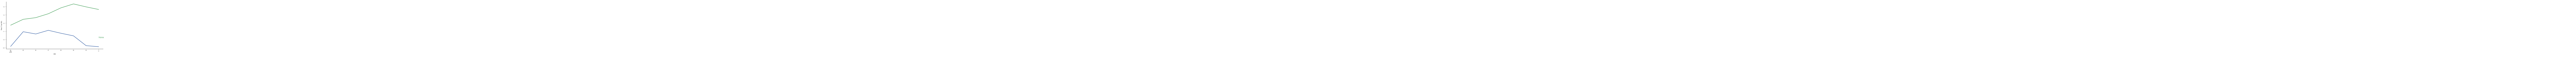

In [14]:
rest.unstack().stack()
with sns.color_palette() as pal:
    b,g = pal.as_hex()[:2]
ax = (rest.unstack().query('away_team<7')
     .rolling(7)
     .mean()
     .plot(figsize=(12,6),linewidth=3,legend=False))
ax.set(ylabel='Rest (7 day MA)')
ax.annotate("Home", (rest.index[-1][0], 1.02), color=g, size=14)
ax.annotate("Away", (rest.index[-1][0], 0.82), color=b, size=14)
sns.despine()

- 总体来说主场休息天数小于客场休息天数

- The most conenient form will depend on exactly what you're doing. When interacting with databases you'll often deal with long form data. Pandas' DataFrame.plot often expects wide-form data, while seaborn often expect long-form data. Regressions will expect wide-form data. Either way, it's good to be comfortable with stack and unstack (and MultiIndexes) to quickly move between the two.

## Home Court advantage?
We've gone to all that work tidying our dataset, let's put it to use. What's the effect (in terms of probability to win) of being the home team?
### Step 1: Create an outcome variable
We need to create an indicator for whether the home team won. Add it as a column called home_win in games.

In [15]:
df['home_win'] = df.home_points>df.away_points

### Step 2: Find the win percent for each team
- In the 10-minute literature review I did on the topic, it seems like people include a team-strength variable in their regressions. I suppose that makes sense; if stronger teams happened to play against weaker teams at home more often than away, it'd look like the home-effect is stronger than it actually is. We'll do a terrible job of controlling for team strength by calculating each team's win percent and using that as a predictor. It'd be better to use some kind of independent measure of team strength, but this will do for now.
- We'll use a similar melt operation as earlier, only now with the home_win variable we just created.

In [16]:
wins = (pd.melt(df.reset_index(),
               id_vars=['game_id','date','home_win'],
               value_name='team',var_name='is_home',
               value_vars=['home_team','away_team'])
       .assign(win=lambda x: x.home_win==(x.is_home=='home_team'))
       .groupby(['team','is_home'])
       .win
       .agg(['sum','count','mean'])
       .rename(columns=dict(sum='n_wins',
                           count='n_games',
                           mean='win_pct')))
wins

n_wins  n_games   win_pct
team               is_home                             
Atlanta Hawks      away_team     1.0        5  0.200000
                   home_team     1.0        2  0.500000
Boston Celtics     away_team     3.0        4  0.750000
                   home_team     2.0        3  0.666667
Brooklyn Nets      away_team     1.0        5  0.200000
...                              ...      ...       ...
Toronto Raptors    home_team     6.0        6  1.000000
Utah Jazz          away_team     4.0        5  0.800000
                   home_team     0.0        2  0.000000
Washington Wizards away_team     1.0        5  0.200000
                   home_team     0.0        2  0.000000

[60 rows x 3 columns]

/Users/frank-lsy/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


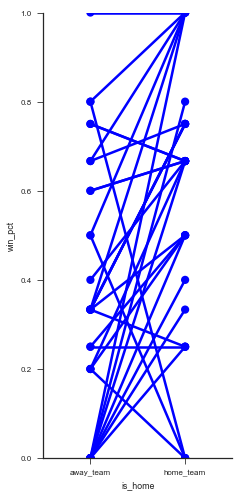

In [17]:
g = sns.FacetGrid(wins.reset_index(),hue='team',size=7,aspect=.5,palette=['b'])
g.map(sns.pointplot,'is_home','win_pct').set(ylim=(0,1))

/Users/frank-lsy/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


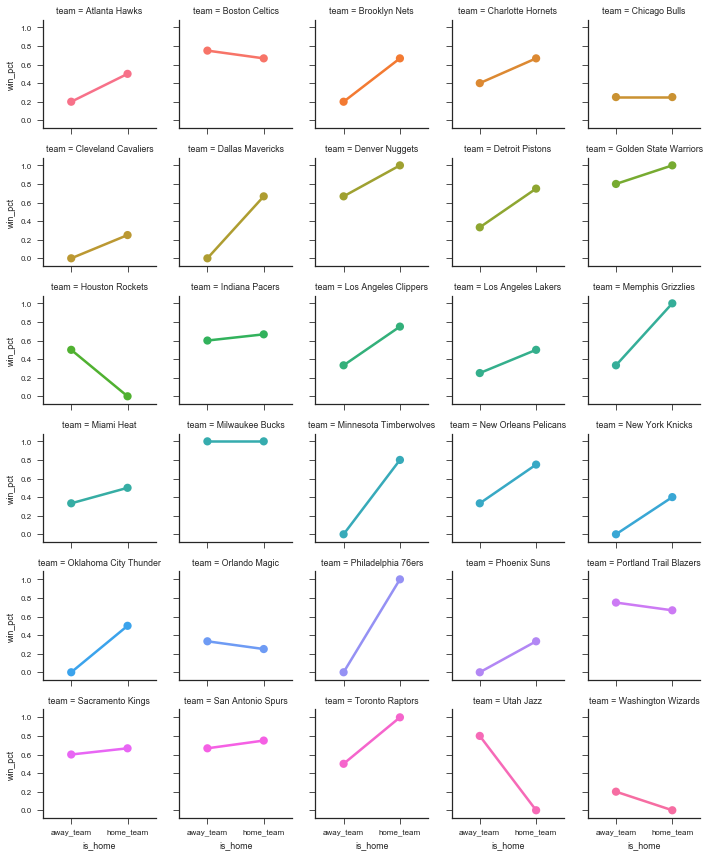

In [18]:
g = sns.FacetGrid(wins.reset_index(),col='team',hue='team',col_wrap=5,size=2)
g.map(sns.pointplot,'is_home','win_pct')

- 多数球队主场比客场胜率高。
下面看一下每支球队的总体胜率情况。

In [19]:
win_percent = (
wins.groupby(level='team',as_index=True)
.apply(lambda x: x.n_wins.sum()/x.n_games.sum()))
win_percent

team
Atlanta Hawks         0.285714
Boston Celtics        0.714286
Brooklyn Nets         0.375000
Charlotte Hornets     0.500000
Chicago Bulls         0.250000
                        ...   
Sacramento Kings      0.625000
San Antonio Spurs     0.714286
Toronto Raptors       0.875000
Utah Jazz             0.571429
Washington Wizards    0.142857
Length: 30, dtype: float64

Text(0.5,86.4,'Win Percent')

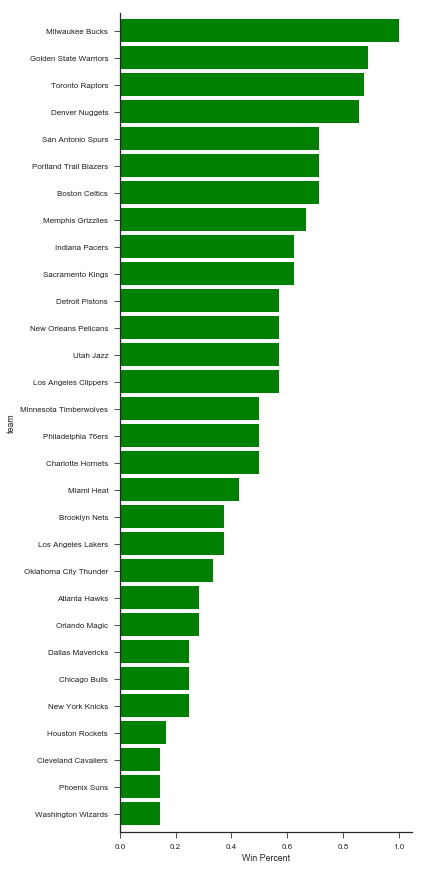

In [20]:
win_percent.sort_values().plot.barh(figsize=(6,12),width=.85,color='g')
plt.tight_layout()
sns.despine()
plt.xlabel('Win Percent')

Is there a relationship between overall team strength and their home-court advantage?

/Users/frank-lsy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


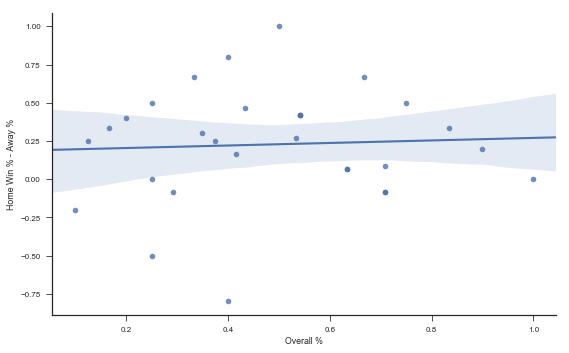

In [21]:
plt.figure(figsize=(8,5))
(wins.win_pct.unstack()
.assign(**{
    'Home Win % - Away %': lambda x: x.home_team-x.away_team,
    'Overall %': lambda x: (x.home_team +x.away_team) /2})
.pipe((sns.regplot,'data'),x='Overall %', y='Home Win % - Away %'))
sns.despine()
plt.tight_layout()

In [22]:
df = df.assign(away_strength=df['away_team'].map(win_percent),
              home_strength=df['home_team'].map(win_percent),
              point_diff=df['home_points']-df['away_points'],
              rest_diff=df['home_rest']-df['away_rest'])
df

,,away_team,away_points,home_team,home_points,attendence,away_rest,home_rest,home_win,rest_spread,away_strength,home_strength,point_diff,rest_diff
game_id,date,,,,,,,,,,,,,
0,2018-10-16,Philadelphia 76ers,87,Boston Celtics,105,18624,NaN,NaN,True,NaN,0.500000,0.714286,18,NaN
1,2018-10-16,Oklahoma City Thunder,100,Golden State Warriors,108,19596,NaN,NaN,True,NaN,0.333333,0.888889,8,NaN
2,2018-10-17,Milwaukee Bucks,113,Charlotte Hornets,112,17889,NaN,NaN,False,NaN,1.000000,0.500000,-1,NaN
3,2018-10-17,Brooklyn Nets,100,Detroit Pistons,103,20332,NaN,NaN,True,NaN,0.375000,0.571429,3,NaN
4,2018-10-17,Memphis Grizzlies,83,Indiana Pacers,111,17923,NaN,NaN,True,NaN,0.666667,0.625000,28,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,2018-10-31,Utah Jazz,125,Minnesota Timberwolves,128,10079,2.0,1.0,True,-1.0,0.571429,0.500000,3,-1.0
106,2018-10-31,Indiana Pacers,107,New York Knicks,101,18295,1.0,1.0,False,0.0,0.625000,0.250000,-6,0.0
107,2018-10-31,New Orleans Pelicans,121,Golden State Warriors,131,19596,1.0,1.0,True,0.0,0.571429,0.888889,10,0.0


In [23]:
import statsmodels.formula.api as sm
df['home_win'] = df.home_win.astype(int)
mod = sm.logit('home_win ~ home_strength + away_strength + home_rest + away_rest',df)
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.398517
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               home_win   No. Observations:                   94
Model:                          Logit   Df Residuals:                       89
Method:                           MLE   Df Model:                            4
Date:                Fri, 22 May 2020   Pseudo R-squ.:                  0.4012
Time:                        01:35:00   Log-Likelihood:                -37.461
converged:                       True   LL-Null:                       -62.557
                                        LLR p-value:                 3.290e-10
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.2122      1.245     -0.170      0.865      -2.652       2.227
home_strength     7.0391      1.631      4.316      0.000       3.843      10.236
away_strength    -4.4310      1.441     -3.075      0.002      -7.255      -1.607
home_rest         0.3624      0.437      0.829      0.407      -0.494       1.219
away_rest        -0.7687      0.441     -1.744      0.081      -1.633       0.095
=================================================================================
"""

The strength variables both have large coefficeints (really we should be using some independent measure of team strength here, win_percent is showing up on the left and right side of the equation). The rest variables don't seem to matter as much.

In [24]:
(sm.Logit.from_formula('home_win ~ strength_diff + rest_spread',
                      df.assign(strength_diff=df.home_strength-df.away_strength))
.fit().summary())

Optimization terminated successfully.
         Current function value: 0.410346
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               home_win   No. Observations:                   94
Model:                          Logit   Df Residuals:                       91
Method:                           MLE   Df Model:                            2
Date:                Fri, 22 May 2020   Pseudo R-squ.:                  0.3834
Time:                        01:35:00   Log-Likelihood:                -38.572
converged:                       True   LL-Null:                       -62.557
                                        LLR p-value:                 3.833e-11
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.6319      0.306      2.065      0.039       0.032       1.232
strength_diff     5.6772      1.154      4.918      0.000       3.415       7.940
rest_spread       0.4121      0.277      1.486      0.137      -0.131       0.956
=================================================================================
"""